In [1]:
import IPython.display as ipd 
import sys
import pyaudio
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show

output_notebook()

Loading BokehJS ...

In [2]:
# plot_library = 'matplotlib'
plot_library = 'matplotlib_xkcd'
# plot_library = 'bokeh'


if (plot_library=='bokeh'):
    import bokeh 
    from bokeh.io import output_notebook
    from bokeh.plotting import figure, output_file, show
    output_notebook()

    def plot(data_list): 
        p = figure(plot_height=300, plot_width=600, title='Synthesizers')
        for data in data_list: 
            p.line(np.arange(0,len(data)), data)
        show(p)
        
if (plot_library=='matplotlib'): 
    %matplotlib notebook 
    import matplotlib.pyplot as plt
    def plot(data_list,label_list=[],xlabel='', ylabel='', title=''):
        fig, ax = plt.subplots(figsize=(8,4))
        for (data,label) in zip(data_list, label_list): 
            plt.title('Synth-CS: '+title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.plot(np.arange(0, len(data)), data, label=label)
        if (label_list):
            ax.legend()
        plt.ion()
        plt.show()
        
if (plot_library=='matplotlib_xkcd'): 
    %matplotlib notebook 
    import matplotlib.pyplot as plt

    def plot(data_list,label_list=[],xlabel='', ylabel='', title=''):
        fig, ax = plt.subplots(figsize=(8,4))  
        plt.xkcd()
        if not(label_list):
            for (i,d) in enumerate(data_list): 
                label_list.append(str(i))
        for (data,label) in zip(data_list, label_list): 
            plt.title('Synth-CS: '+title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.plot(np.arange(0, len(data)), data, label=label)  
            ax.legend()
        plt.ion()
        plt.show()
    

In [3]:
# let's define some basic periodic waveforms
def sawtooth(x):
    return (x - np.pi)/np.pi

def square(x):
    return np.sign(sawtooth(x))

def triangle(x):
    return 1 - 2 * np.abs(sawtooth(x))


def create_wavetable(length, fn):
    L = length+1 # add one sample to wavetable to allow edge interpolation
    t = np.linspace(0, 1.0 , L)
    wavetable = fn(2 * np.pi * t)
    return wavetable

# wavetable look (truncate and round only use one sample), 
# interpolate uses two samples and is more accurate 
def wavetable_lookup(phase_index, wavetable, mode): 
    if (mode == 'truncate'): 
        return wavetable[int(phase_index)]
    elif (mode == 'round'): 
        return wavetable[round(phase_index)]
    elif (mode == 'interpolate'): 
        x  = phase_index
        x0 = int(phase_index)
        x1 = x0+1
        y0 = wavetable[x0]
        y1 = wavetable[x1]
        return y0 * (x1-x) + y1 * (x - x0)
    else:
        return 0.0 

def oscillator(freq, wavetable, nsamples, phase_index): 
    table_length = wavetable.shape[0]
    for t in np.arange(nsamples): 
        phase_increment = (table_length * freq) / srate 
        phase_index = (phase_index + phase_increment) % table_length
        sample = wavetable_lookup(phase_index, wavetable, mode='interpolate')
        data[t] = sample
    return (phase_index, data)

Eventually we want to have a synthesizer that can generate sound in real-time in response to things like MIDI messages or GUI events. There are two styles of audio playback interfaces. Blocking audio playback writes data in small buffers to the audio device. The write functions in the code below block until the audio is played. Notice that the phase_index needs to be properly updated while multiple calls to the oscillator function are made. In this implementation this is achieved by the oscillator returning the phase index and having it as an argument. An alternative shown later in this notebook is to make the oscillator an object and  have the phase index as part of 
the state of the object. 

<IPython.core.display.Javascript object>


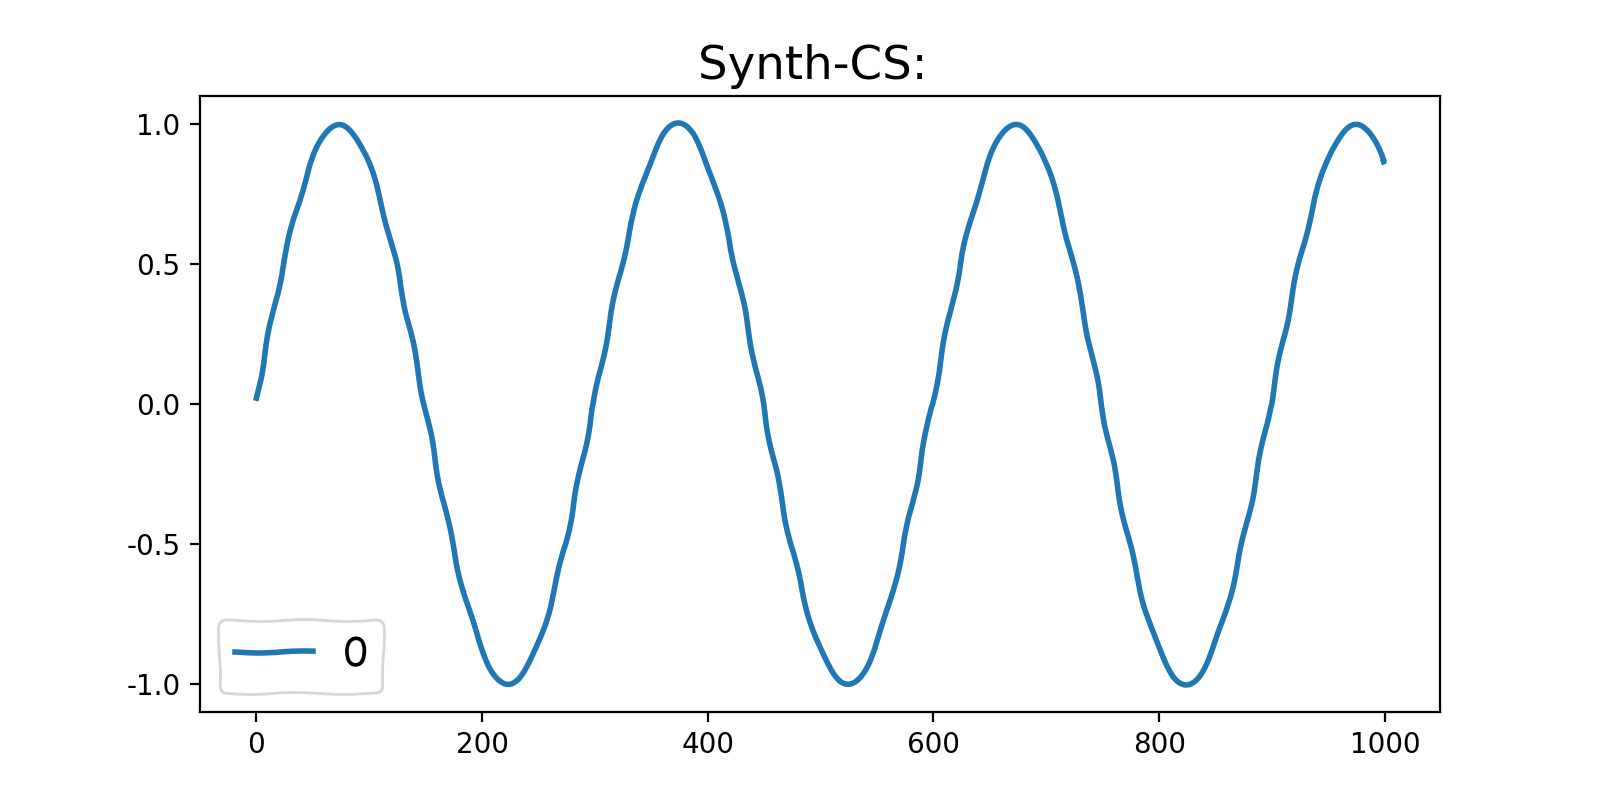

In [4]:
        
table_length = 1000
wavetable = create_wavetable(table_length, np.sin)
srate = 48000 
freq = 160
phase_index = 0 

CHUNK = 1024
# Instantiate PyAudio and initialize PortAudio system resources (1)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True)

data = np.zeros(CHUNK)
(phase_index, data) = oscillator(160.0, wavetable, CHUNK, phase_index)
plot([data[0:1000]])

In [5]:
# Generate small buffers of CHUNK size and play using blocking write calls 
for i in np.arange(0, 100):        
    (phase_index, data) = oscillator(160.0, wavetable, CHUNK, phase_index)
    stream.write(data.astype(np.float32).tobytes())
    

<IPython.core.display.Javascript object>


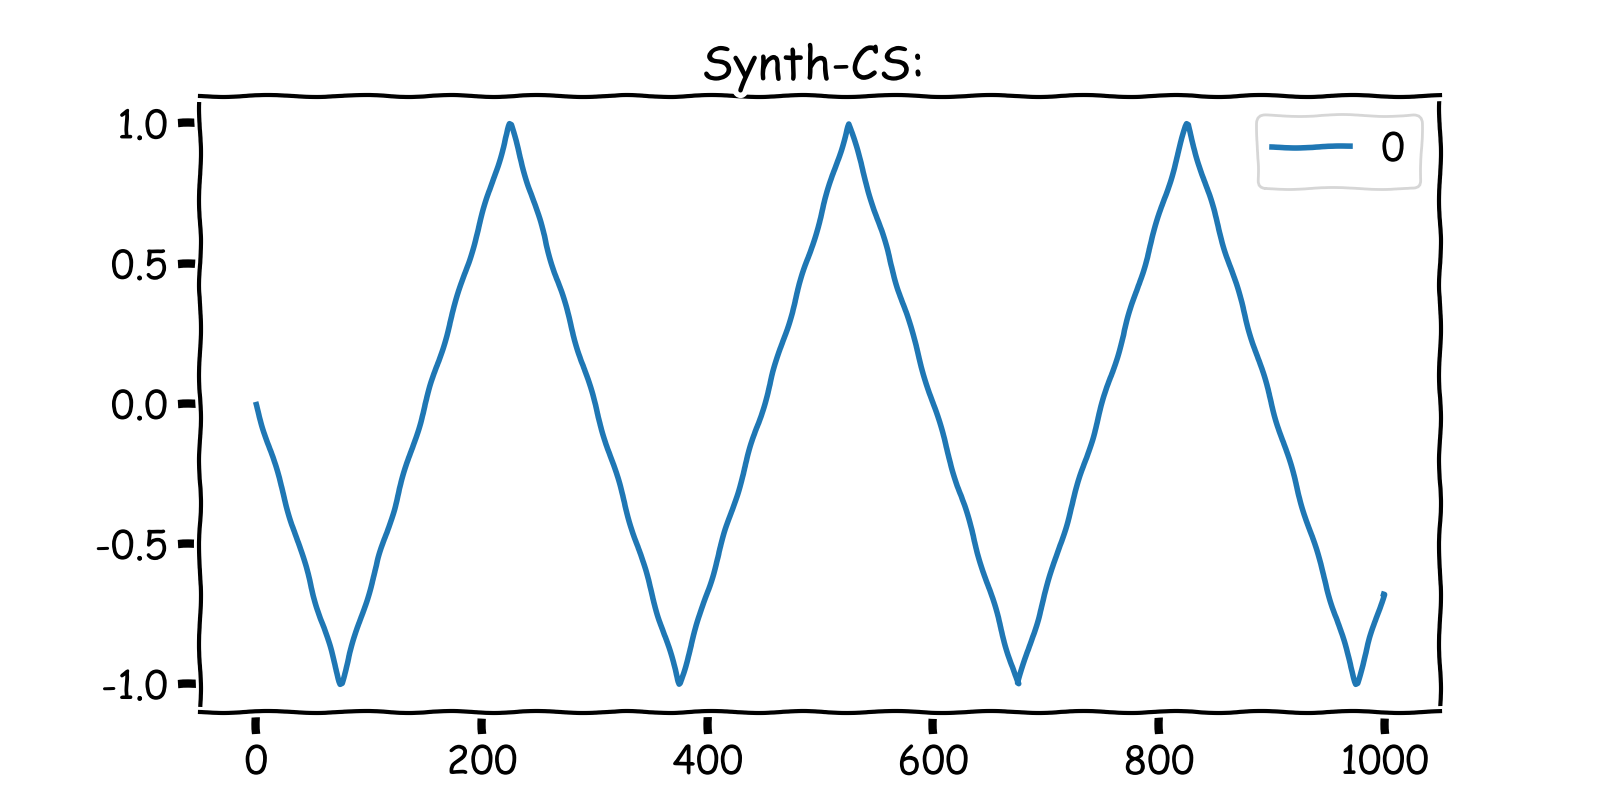

In [6]:
# Play a different oscillator (triangle)
wavetable = create_wavetable(table_length, triangle) 
(phase_index, data) = oscillator(160.0, wavetable, CHUNK, phase_index)
plot([data[0:1000]])

In [7]:
for i in np.arange(0, 100):        
    (phase_index, data) = oscillator(160.0, wavetable,CHUNK,phase_index) 
    stream.write(data.astype(np.float32).tobytes())
    
stream.close()
p.terminate()

Let's use an object for the wavetable oscillator. That way we can 
initilize the state of the oscillator with things like the wavetable the frequency, and the phase index. 

In [8]:
import pyaudio 
import numpy as np 

class WavetableOscillator:
    
    def create_wavetable(self, length, fn): 
        L = length+1 # add one sample to wavetable to allow edge interpolation
        t = np.linspace(0, 1.0 , L)
        wavetable = fn(2 * np.pi * t)
        return wavetable
    
    def wavetable_lookup(self,phase_index, wavetable, mode): 
        if (mode == 'truncate'): 
            return wavetable[int(phase_index)]
        elif (mode == 'round'): 
            return wavetable[round(phase_index)]
        elif (mode == 'interpolate'): 
            x  = phase_index
            x0 = int(phase_index)
            x1 = x0+1
            y0 = wavetable[x0]
            y1 = wavetable[x1]
            return y0 * (x1-x) + y1 * (x - x0)
        else:
            return 0.0 

    def __init__(self, nsamples=1024):
        self.phase_index = 0.0 
        table_length = 1000 
        self.wavetable = self.create_wavetable(table_length, np.sin)
        self.table_length = table_length
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.freq = 220.0
        self.amp = 1.0 
        self.srate = 48000 
        
    def set_freq(self, freq): 
        self.freq = freq 
        
    def set_amp(self, amp): 
        self.amp = amp 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        
    def process(self): 
        for t in np.arange(self.nsamples): 
            phase_increment = (self.table_length * self.freq) / self.srate 
            self.phase_index = (self.phase_index + phase_increment) % self.table_length
            sample = self.wavetable_lookup(self.phase_index, self.wavetable, mode='interpolate')
            self.data[t] = self.amp * sample
            # print('phase index', self.phase_index)
        return self.data 

We can use the same approach for playback. It is also straightforward to have multiple oscillators 
and support polyphonic playback

In [9]:
CHUNK = 1024
# Instantiate PyAudio and initialize PortAudio system resources (1)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True)
        
        
osc1 = WavetableOscillator(nsamples=CHUNK)
osc2 = WavetableOscillator(nsamples=CHUNK)
osc2.set_freq(100)

for i in np.arange(0, 100): 
    data1 = osc1.process()
    data2 = osc2.process()
    data = 0.5 * (data1 + data2)
    stream.write(data.astype(np.float32).tobytes())

stream.close()
p.terminate()

KeyboardInterrupt: 

We can create random sounds by combining sinusoidal oscillators with random frequencies and amplitudes. 
Notice that we need to be able to compute all the samples in time in order for the blocking playback to work. 
As the polyphony is increased we will start hearing cliks when the sample generation process of the oscillators 
is not able to be computed in time. On my laptop the maximum polyphony is around 18 oscillators. 


In [ ]:
polyphony = 5

CHUNK = 1024
# Instantiate PyAudio and initialize PortAudio system resources (1)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True)
oscillators = []     

for i in range(1,polyphony+1): 
    oscillators.append(WavetableOscillator(nsamples=CHUNK))
    oscillators[i-1].set_freq(np.random.randint(100, 1000))
    oscillators[i-1].set_amp(np.random.randn())

    
data = np.zeros(CHUNK)
for t in np.arange(0, 100): 
    for i in range(1,polyphony+1): 
        data += oscillators[i-1].process()
        data *= 0.1  
    stream.write(data.astype(np.float32).tobytes())

plot([data])
stream.close()
p.terminate()

Using the object-oriented oscillator, we can also show the **callback style** of interacting with the audio device. In this approach, we proviee a callback function to generate the samples as needed and this function is called by PyAudio whenever samples are needed to maintain real-time audio playback. 

In [ ]:
import time 
osc1 = WavetableOscillator(nsamples=64)

def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)
    # here is where you would deal with MIDI or GUI events 
    data = osc1.process()
    return (data.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                stream_callback=callback)

time.sleep(1.5)
print('Playback done')
stream.close()
p.terminate()

In [ ]:
polyphony = 8


for i in range(1,polyphony+1): 
    oscillators.append(WavetableOscillator(nsamples=64))
    oscillators[i-1].set_freq(np.random.randint(100, 1000))
    oscillators[i-1].set_amp(np.random.randn())


def callback(in_data, frame_count, time_info, status):
    # here is where you would deal with MIDI or GUI events 
    data = np.zeros(frame_count)
    for i in range(1,polyphony+1): 
        oscillators[i-1].set_nsamples(frame_count)
        data += oscillators[i-1].process()
    return (data.astype(np.float32).tobytes(), pyaudio.paContinue)


 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                stream_callback=callback)

time.sleep(3.0)
print('Playback done')
stream.close()
p.terminate()

We extend our approach with adding amplitude modulation and envelopes by appropriately defining an object that handles the generation of the envelope signal. Here is an example of a simple attack ramp. It is straighforward to extend/generalize it to a ADSR envelope. The attack ramp responds to a note on event. 

In [ ]:
class AttackRamp: 
    def __init__(self, nsamples=1024):
        self.duration = 48000 
        self.nsamples = nsamples 
        self.data = np.zeros(self.nsamples)
        self.amp = 0.0 
        self.noteon = False 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        
    def note_on(self): 
        self.noteon = True 
        
    def process(self): 
        if (self.noteon): 
             amp_increment = 1.0 / self.duration 
        else: 
            amp_increment = 0.0 
        
        for t in np.arange(self.nsamples): 
            self.amp = self.amp + amp_increment 
            if self.amp > 1.0: 
                self.amp = 1.0 
                self.noteon = False 
            self.data[t] = self.amp 

        return self.data
    
class WavetableOscillator:
    
    def create_wavetable(self, length, fn): 
        L = length+1 # add one sample to wavetable to allow edge interpolation
        t = np.linspace(0, 1.0 , L)
        wavetable = fn(2 * np.pi * t)
        return wavetable
    
    def wavetable_lookup(self,phase_index, wavetable, mode): 
        if (mode == 'truncate'): 
            return wavetable[int(phase_index)]
        elif (mode == 'round'): 
            return wavetable[round(phase_index)]
        elif (mode == 'interpolate'): 
            x  = phase_index
            x0 = int(phase_index)
            x1 = x0+1
            y0 = wavetable[x0]
            y1 = wavetable[x1]
            return y0 * (x1-x) + y1 * (x - x0)
        else:
            return 0.0 

    def __init__(self, amp_modulator, nsamples=1024):
        self.phase_index = 0.0 
        table_length = 1000 
        self.wavetable = self.create_wavetable(table_length, np.sin)
        self.table_length = table_length
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.freq = 220.0
        self.srate = 48000 
        self.amp = 1.0 
        self.amp_modulator = amp_modulator 
        self.noteon = False
        
    def note_on(self): 
        self.noteon = True 
        self.amp_modulator.note_on()
        
    def set_freq(self, freq): 
        self.freq = freq 
        
    def set_amp(self, amp): 
        self.amp = amp 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.amp_modulator.set_nsamples(self.nsamples)
        
    def process(self): 
        amplitudes = self.amp_modulator.process()
        for t in np.arange(self.nsamples): 
            phase_increment = (self.table_length * self.freq) / self.srate 
            self.phase_index = (self.phase_index + phase_increment) % self.table_length
            sample = self.wavetable_lookup(self.phase_index, self.wavetable, mode='interpolate')
            self.data[t] = self.amp * amplitudes[t] * sample
        return self.data   

We can now use the wavetable oscillator combined with the attack ramp envelope to have a more smooth starting sound. 

In [ ]:
duration_samples = 48000 * 2 
chunk_size = 64
iterations = int(duration_samples / chunk_size) 

amp_env = AttackRamp(chunk_size) 
osc1 = WavetableOscillator(amp_env, chunk_size)
audio_data = np.zeros(duration_samples)
audio_buffers = []
for i in np.arange(0,iterations): 
    data = osc1.process() 
    
    # trigger a note on event at a particular time 
    if (i == iterations / 4): 
        osc1.note_on()
        
        
    nsamples = data.shape[0]
    for t in np.arange(0,nsamples): 
        audio_data[i * nsamples + t] = data[t]
plot([audio_data])
plot([audio_data[30000:44000]])



ipd.Audio(audio_data, rate=48000)


It is also straightforward to use this approach with the callback style and buffered audio playback. For fun we can add real-time control of the frequency and amplitude using the mouse x and y coordinates to control the pitch and amplitude like a Theremin - while we are at it we can add a oscilloscope like plot. 

In [ ]:
import time 
import pyautogui
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#plt.xkcd()

chunk_size = 1024

amp_env = AttackRamp(chunk_size) 
osc1 = WavetableOscillator(amp_env, chunk_size)
data_ = np.zeros(chunk_size)
osc1.note_on()

data_ = osc1.process()
fig = plt.figure()
ax = plt.axes()

x = np.arange(0, len(data_))
line, = ax.plot(x, data_)
plt.ion()
plt.show()

screen_height = pyautogui.size().height
screen_width = pyautogui.size().width 


In [ ]:
def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)    
    global data_
    data_ = osc1.process()
    return (data_.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                frames_per_buffer=1024,
                stream_callback=callback)

import time
t_end = time.time() + 10

# run the loop for 10 seconds 

while time.time() < t_end:
    cursor_position = pyautogui.position()
    amp = 0.5 * (screen_height - cursor_position.y) / screen_height
    osc1.set_freq(cursor_position.x)
    osc1.set_amp(amp)
    line.set_ydata(data_)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()
    if time.time() > t_end: 
        break


print('Playback done')
stream.close()
p.terminate()

The AttackRamp is a simplified version of the more common Attack, Decay, Sustain, Release envelope and only partially handles NoteOn events. It is relatively straightforward to write an ADSR amplitude envelope that correctly supports NoteOn, NoteOff events and has all four stages. The ADSR envelope generator should always produce samples (zeros when there is no envelope) and have the number of samples generated be adjustable. 


In [ ]:
import bokeh 
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.io import push_notebook, show, output_notebook
    
chunk_size = 1024

amp_env = AttackRamp(chunk_size) 
osc1 = WavetableOscillator(amp_env, chunk_size)
data_ = np.zeros(chunk_size)
osc1.note_on()
data_ = osc1.process()

output_notebook()
x = np.arange(0, len(data_))
line, = ax.plot(x, data_)
p = figure(plot_height=300, plot_width=600, title='Synthesizers')
l = p.line(np.arange(0,len(data_)), data_)

screen_height = pyautogui.size().height
screen_width = pyautogui.size().width 
t = show(p, notebook_handle=True)
    
def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)    
    global data_
    data_ = osc1.process()
    return (data_.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                frames_per_buffer=1024,
                stream_callback=callback)

import time
t_end = time.time() + 10

# run the loop for 10 seconds 
while time.time() < t_end:
    cursor_position = pyautogui.position()
    amp = 0.5 * (screen_height - cursor_position.y) / screen_height
    osc1.set_freq(cursor_position.x)
    osc1.set_amp(amp)
    l.data_source.data['y'] = data_
    push_notebook(handle=t)
    
    if time.time() > t_end: 
        break
    time.sleep(0.01)
    
print('Playback done')
stream.close()
p.terminate()

In [ ]:
import sounddevice as sd
sd.query_devices()

There is a lot more work that could go into our little synthesizer simulation. More flexible representations of time (samples, seconds, beats with time-varying tempo) are possible and can be used for triggering events such as note on and note off. More flexible representations of frequency (MIDI note number, music notation string, frequency in Hz, frequency in cents, scale number connected to scale specified by frequencies to support multiple tuning systems). 
In addition to amplitude modulation, we can add frequency and phase modulation. 

A proper object oriented hierarchy could be made with abstract classes for oscillators, mutators etc with specific instances for particular waveforms. Both single timbre polyphony and multi-timbrality can be added as well as 
operators on the oscillators such as adders and multipliers. 

Using just sinusoidal oscillators and amplitude envelopes it is possible to create some pretty cool sounds. 
Check out this notebook for how to recreate the iconic THX sound logo using Python. After the material covered in this notebook You should be able to understand the code behind the THX logo. A good exercise it to rewrite the code to use wavetable oscillators instead of direct computation and create a real-time version. 

https://colab.research.google.com/github/stevetjoa/musicinformationretrieval.com/blob/gh-pages/thx_logo_theme.ipynb


### TO DO 

The following items are interesting things to work on either on your or I might add them at some point to the notebook. 

1. Make full ADSR envelope 
2. Include frequency sweep and lfo frequency modulation using the wavetable oscillators 
3. Add MIDI input using PyGame
4. Add real-time visualizations of the waveforms using Boreal 
5. Include some historical information about Max Mathews and the IBM 704 (especially about memory and tape capacity) 




